In [1]:
#!/usr/bin/env python
from math import ceil
from random import uniform
import argparse
import os

import tensorflow as tf

from adain.nn import build_vgg, vgg_layer_params, build_decoder
from adain.norm import adain
from adain.util import get_params
from adain.weights import open_weights

import numpy as np
import numpy as np
import numba
from numba import njit, prange
from numba import cuda
import copy
import sys
import time
import matplotlib.pyplot as plt
import pydicom
import glob

from skimage.measure import label
from scipy.io import loadmat
from scipy.ndimage import zoom
#from scipy.misc import imresize
import pywt

import csv
import random
import time
%matplotlib inline  

from scipy import ndimage, misc

import pywt
#import hdf5storage

import scipy.io as sio
from skimage.filters import threshold_otsu


In [2]:
# All Imports

import numpy as np
import numba
from numba import njit, prange
from numba import cuda
import copy
import sys
import time
import matplotlib.pyplot as plt
import pydicom
import glob
from skimage import filters
from skimage.filters import unsharp_mask, threshold_local, threshold_minimum
import keras
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, GaussianNoise
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers import MaxPooling2D, merge
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras import losses
from keras.utils import to_categorical
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import glob

from skimage.measure import compare_ssim as ssim



import numba
from numba import njit, prange

from keras import backend as K
from keras.layers import Layer

import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, Callback, TensorBoard
from keras import backend as keras

from skimage.measure import label
from scipy.io import loadmat
from scipy.ndimage import zoom
#from scipy.misc import imresize
import pywt

import csv
import random
import time
%matplotlib inline  

from scipy import ndimage, misc

import pywt
#import hdf5storage

import scipy.io as sio
from skimage.filters import threshold_otsu

#import pylidc as pl
#from keras.backend.tensorflow_backend import set_session
import tensorflow as tf


from keras.models import Sequential
from keras.layers.convolutional import Conv3D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers.normalization import BatchNormalization

import pywt
import numpy as np
#import pydicom
import matplotlib.pyplot as plt
import SimpleITK as sitk
import skimage.io as io
#from sklearn.decomposition import PCA
import collections, numpy
import warnings
from scipy import ndimage, misc
warnings.filterwarnings('ignore')

#import pymrt as mrt
#import pymrt.geometry
import ipyvolume as ipv
import copy


import os
import glob
import uuid
import numpy as np
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from ipdb import set_trace as bp



#from image_gen import ImageDataGenerator
#from load_data import loadDataMontgomery, loadDataJSRT
#from build_model import build_UNet2D_4L

import pandas as pd
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint



import numpy
import warnings
from keras.layers import Convolution3D, Input, merge, RepeatVector, Activation
from keras.models import Model
from keras.layers.advanced_activations import PReLU
from keras import activations, initializers, regularizers
from keras.engine import Layer, InputSpec
from keras.utils.conv_utils import conv_output_length
#from keras.utils.np_utils import conv_output_length
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
import keras.backend as K
from keras.engine.topology import Layer
import functools
import tensorflow as tf
import pickle
import time

Using TensorFlow backend.


In [247]:
# Train Code

x_array = np.load("x_array.npy")
y_array = np.load("y_array.npy")
z_array = np.load("z_array.npy")

def get_my_batch():
    global x_array, y_array
    
    perm    = np.random.permutation(len(x_array))
    x_array = np.array(x_array)[perm]
    y_array = np.array(y_array)[perm]
    
    content_images = []
    style_images   = []
    
    for i in range(8):
        temp = [x_array[i, :, :, 0], x_array[i, :, :, 0], x_array[i, :, :, 0]]
        content_images.append(temp)
        
        temp = [y_array[i, :, :, 0], y_array[i, :, :, 0], y_array[i, :, :, 0]]
        style_images.append(temp)
       
    #content_images = x_array[:8, :, :, 0]
    #style_images   = y_array[:8, :, :, 0]
    
    #content_images = np.concatenate([content_images, content_images, content_images], axis=-1)
    #style_images   = np.concatenate([style_images, style_images, style_images], axis=-1)
    
    return np.array(content_images)*5, np.array(style_images)*5
    

def train(
        content_dir='datasets/coco',
        style_dir='datasets/wikiart',
        checkpoint_dir='checkpoints',
        decoder_activation='relu',
        initial_size=512,
        random_crop_size=256,
        resume=True,
        optimizer='adam',
        learning_rate=1e-5,
        learning_rate_decay=0,#5e-5,
        momentum=0.9,
        batch_size=8,
        num_epochs=16,
        content_layer='conv4_1',
        style_layers='conv1_1,conv2_1,conv3_1,conv4_1',
        tv_weight=0,
        style_weight=0.0001,
        content_weight=1,
        save_every=2000,
        print_every=10,
        gpu=0,
        vgg='models/vgg19_weights_normalized.h5'):
    
    tf.reset_default_graph()
    #assert initial_size >= random_crop_size, 'Images are too small to be cropped'
    #assert gpu >= 0, 'CPU mode is not supported'

    #os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu)
    
    #if not os.path.exists(checkpoint_dir):
    #    print('Creating checkpoint dir at', checkpoint_dir)
    #    os.mkdir(checkpoint_dir)

    style_layers = style_layers.split(',')
    
    # the content layer is also used as the encoder layer
    encoder_layer = content_layer
    encoder_layer_filters = vgg_layer_params(encoder_layer)['filters']
    encoder_layer_shape   = (None, encoder_layer_filters, None, None)


    # decoder->encoder setup
    if decoder_activation == 'relu':
        decoder_activation = tf.nn.relu
    elif decoder_activation == 'elu':
        decoder_activation = tf.nn.elu
    else:
        raise ValueError('Unknown activation: ' + decoder_activation)
    
    input_image_shape = (None, 3, 128, 128)
    
    for_mae_loss    = tf.placeholder(tf.float32, shape=input_image_shape)
    
    content_encoded = tf.placeholder(tf.float32, shape=encoder_layer_shape)
    style_encoded   = tf.placeholder(tf.float32, shape=encoder_layer_shape)
    output_encoded  = adain(content_encoded, style_encoded)
    
    images = build_decoder(output_encoded, weights=None, trainable=True,
        activation=decoder_activation)
    
    #print(images, tf.shape(images))
    #return
    
    with open_weights(vgg) as w:
        vgg     = build_vgg(images, w, last_layer=encoder_layer)
        encoder = vgg[encoder_layer]


    # loss setup
    # content_target, style_targets will hold activations of content and style
    # images respectively
    content_layer  = vgg[content_layer]
    content_target = tf.placeholder(tf.float32, shape=encoder_layer_shape)
    
    style_layers = {layer: vgg[layer] for layer in style_layers}
    style_targets = {
        layer: tf.placeholder(tf.float32, shape=style_layers[layer].shape)
        for layer in style_layers
    }

    content_loss = build_content_loss(content_layer, content_target, content_weight)
    style_losses = build_style_losses(style_layers, style_targets, style_weight)
    
    #loss = content_loss + tf.reduce_sum(list(style_losses.values()))
    
    
    if tv_weight:
        tv_loss = tf.reduce_sum(tf.image.total_variation(images)) * tv_weight
    else:
        tv_loss = tf.constant(0, dtype=tf.float32)
    #loss += tv_loss
    
    loss = tf.reduce_sum(tf.keras.losses.mean_absolute_error(for_mae_loss, images))
    #loss    += 0.01*mae_loss 

    # training setup
    #batch = setup_input_pipeline(content_dir, style_dir, batch_size,
    #    num_epochs, initial_size, random_crop_size)

    global_step = tf.Variable(0, trainable=False, name='global_step')
    rate = tf.train.inverse_time_decay(learning_rate, global_step,
        decay_steps=1, decay_rate=learning_rate_decay)

    if optimizer == 'adam':
        optimizer = tf.train.AdamOptimizer(rate, beta1=momentum)
    elif optimizer == 'sgd':
        optimizer = tf.train.GradientDescentOptimizer(rate)
    else:
        raise ValueError('Unknown optimizer: ' + optimizer)

    train_op = optimizer.minimize(loss, global_step=global_step)

    saver = tf.train.Saver()

    with tf.Session() as sess:
        sess.run(tf.local_variables_initializer())

        if resume:
            latest = tf.train.latest_checkpoint(checkpoint_dir)
            saver.restore(sess, latest)
        else:
            sess.run(tf.global_variables_initializer())

        coord   = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(sess=sess, coord=coord)

        with coord.stop_on_exception():
            while not coord.should_stop():
                content_batch, style_batch = get_my_batch()
                #content_batch, style_batch = sess.run(batch)

                # step 1
                # encode content and style images,
                # compute target style activations,
                # run content and style through AdaIN
                content_batch_encoded = sess.run(encoder, feed_dict={
                    images: content_batch
                })

                style_batch_encoded, style_target_vals = sess.run([encoder, style_layers], feed_dict={
                    images: style_batch
                })

                output_batch_encoded = sess.run(output_encoded, feed_dict={
                    content_encoded: content_batch_encoded,
                    style_encoded: style_batch_encoded
                })

                # step 2
                # run the output batch through the decoder, compute loss
                feed_dict = {
                    output_encoded: output_batch_encoded,
                    # "We use the AdaIN output as the content target, instead of
                    # the commonly used feature responses of the content image"
                    content_target: output_batch_encoded
                }
                for layer in style_targets:
                    feed_dict[style_targets[layer]] = style_target_vals[layer]
                
                feed_dict[for_mae_loss] = style_batch
                
                #allkeys = feed_dict.keys()
                #print("All keys are")
                #for kt in allkeys:
                #    print(kt)
                #print()
                #return 0, 1, 2
                
                fetches = [train_op, loss, content_loss, style_losses, tv_loss, global_step, images]
                result  = sess.run(fetches, feed_dict=feed_dict)
                _, loss_val, content_loss_val, style_loss_vals, tv_loss_val, i, output_result = result
                
                #print("MAE loss is ", mae_loss_val)
                
                if i % print_every == 0:
                    style_loss_val  = sum(style_loss_vals.values())
                    style_loss_vals = '\t'.join(sorted(['%s = %0.4f' % (name, val) for name, val in style_loss_vals.items()]))
                    print(i,
                        'loss = %0.4f' % loss_val,
                        'content = %0.4f' % content_loss_val,
                        'style = %0.4f' % style_loss_val,
                        style_loss_vals,
                        'tv = %0.4f' % tv_loss_val, sep='\t')
                    print(output_result.shape, np.mean(output_result), np.mean(content_batch), np.mean(style_batch))

                if i % save_every == 0:
                    print('Saving checkpoint')
                    saver.save(sess, os.path.join(checkpoint_dir, 'adain'), global_step=i)

        coord.join(threads)
        saver.save(sess, os.path.join(checkpoint_dir, 'adain-final'))


def build_content_loss(current, target, weight):
    loss = tf.reduce_mean(tf.squared_difference(current, target))
    loss *= weight
    return loss


def build_style_losses(current_layers, target_layers, weight, epsilon=1e-6):
    losses = {}
    for layer in current_layers:
        current, target = current_layers[layer], target_layers[layer]

        current_mean, current_var = tf.nn.moments(current, axes=[2,3], keep_dims=True)
        current_std = tf.sqrt(current_var + epsilon)

        target_mean, target_var = tf.nn.moments(target, axes=[2,3], keep_dims=True)
        target_std = tf.sqrt(target_var + epsilon)

        #diff_loss = tf.reduce_sum(tf.squared_difference(current, target))
        mean_loss = tf.reduce_sum(tf.squared_difference(current_mean, target_mean))
        std_loss = tf.reduce_sum(tf.squared_difference(current_std, target_std))

        # normalize w.r.t batch size
        n = tf.cast(tf.shape(current)[0], dtype=tf.float32)
        
        #diff_loss /= n
        mean_loss /= n
        std_loss /= n
        
        #losses[layer] = diff_loss * weight
        losses[layer] = (mean_loss + std_loss) * weight
    return losses



In [ ]:
train()

In [249]:
# Transfer Style Code Test Code

x_array = np.load("x_array.npy")
y_array = np.load("y_array.npy")


def test(
        content_dir='datasets/coco',
        style_dir='datasets/wikiart',
        checkpoint_dir='checkpoints',
        decoder_activation='relu',
        initial_size=512,
        random_crop_size=256,
        resume=False,
        optimizer='adam',
        learning_rate=1e-5,
        learning_rate_decay=0,#5e-5,
        momentum=0.9,
        batch_size=8,
        num_epochs=16,
        content_layer='conv4_1',
        style_layers='conv1_1,conv2_1,conv3_1,conv4_1',
        tv_weight=0,
        style_weight=100,
        content_weight=10000,
        save_every=2000,
        print_every=10,
        gpu=0,
        vgg='models/vgg19_weights_normalized.h5'):
    
    #assert initial_size >= random_crop_size, 'Images are too small to be cropped'
    #assert gpu >= 0, 'CPU mode is not supported'

    #os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu)
    
    #if not os.path.exists(checkpoint_dir):
    #    print('Creating checkpoint dir at', checkpoint_dir)
    #    os.mkdir(checkpoint_dir)
    tf.reset_default_graph()
    
    style_layers = style_layers.split(',')
    
    # the content layer is also used as the encoder layer
    encoder_layer = content_layer
    encoder_layer_filters = vgg_layer_params(encoder_layer)['filters']
    encoder_layer_shape = (None, encoder_layer_filters, None, None)


    # decoder->encoder setup
    if decoder_activation == 'relu':
        decoder_activation = tf.nn.relu
    elif decoder_activation == 'elu':
        decoder_activation = tf.nn.elu
    else:
        raise ValueError('Unknown activation: ' + decoder_activation)

    content_encoded = tf.placeholder(tf.float32, shape=encoder_layer_shape)
    style_encoded   = tf.placeholder(tf.float32, shape=encoder_layer_shape)
    output_encoded  = adain(content_encoded, style_encoded)
    
    images = build_decoder(output_encoded, weights=None, trainable=True,
        activation=decoder_activation)
    
    #print(images, tf.shape(images))
    #return
    
    with open_weights(vgg) as w:
        vgg     = build_vgg(images, w, last_layer=encoder_layer)
        encoder = vgg[encoder_layer]


    # loss setup
    # content_target, style_targets will hold activations of content and style
    # images respectively
    content_layer  = vgg[content_layer]
    content_target = tf.placeholder(tf.float32, shape=encoder_layer_shape)
    style_layers   = {layer: vgg[layer] for layer in style_layers}
    style_targets  = {
        layer: tf.placeholder(tf.float32, shape=style_layers[layer].shape)
        for layer in style_layers
    }

    content_loss = build_content_loss(content_layer, content_target, content_weight)
    style_losses = build_style_losses(style_layers, style_targets, style_weight)
    
    loss         = content_loss + tf.reduce_sum(list(style_losses.values()))

    if tv_weight:
        tv_loss = tf.reduce_sum(tf.image.total_variation(images)) * tv_weight
    else:
        tv_loss = tf.constant(0, dtype=tf.float32)
    loss += tv_loss


    # training setup
    #batch = setup_input_pipeline(content_dir, style_dir, batch_size,
    #    num_epochs, initial_size, random_crop_size)

    global_step = tf.Variable(0, trainable=False, name='global_step')
    rate = tf.train.inverse_time_decay(learning_rate, global_step,
        decay_steps=1, decay_rate=learning_rate_decay)

    if optimizer == 'adam':
        optimizer = tf.train.AdamOptimizer(rate, beta1=momentum)
    elif optimizer == 'sgd':
        optimizer = tf.train.GradientDescentOptimizer(rate)
    else:
        raise ValueError('Unknown optimizer: ' + optimizer)

    train_op = optimizer.minimize(loss, global_step=global_step)

    saver = tf.train.Saver()

    with tf.Session() as sess:
        sess.run(tf.local_variables_initializer())

        #if resume:
        latest = tf.train.latest_checkpoint(checkpoint_dir)
        saver.restore(sess, latest)
        #else:
        #    sess.run(tf.global_variables_initializer())

        content_batch, style_batch = get_my_batch()
        #content_batch, style_batch = sess.run(batch)

        # step 1
        # encode content and style images,
        # compute target style activations,
        # run content and style through AdaIN
        content_batch_encoded = sess.run(encoder, feed_dict={
            images: content_batch
        })

        style_batch_encoded, style_target_vals = sess.run([encoder, style_layers], feed_dict={
            images: style_batch
        })
        
        print(style_batch_encoded.shape, style_target_vals.keys())
        
        #print(content_batch_encoded.shape, style_batch_encodedstyle_batch_encoded.shape, style_target_vals.shape)
        output_batch_encoded = sess.run(output_encoded, feed_dict={
            content_encoded: content_batch_encoded,
            style_encoded: style_batch_encoded
        })

        # step 2
        # run the output batch through the decoder, compute loss
        feed_dict = {
            output_encoded: output_batch_encoded,
            # "We use the AdaIN output as the content target, instead of
            # the commonly used feature responses of the content image"
            content_target: output_batch_encoded
        }
        for layer in style_targets:
            feed_dict[style_targets[layer]] = style_target_vals[layer]

        #fetches = [train_op, loss, content_loss, style_losses, tv_loss, global_step, images]
        #result = sess.run(fetches, feed_dict=feed_dict)
        #_, loss_val, content_loss_val, style_loss_vals, tv_loss_val, i, output_result = result
        
        fetches = [images]
        [output_result] = sess.run(fetches, feed_dict=feed_dict)
        
        print(output_result.shape, np.mean(output_result))
        
        return content_batch, style_batch, output_result

def build_content_loss(current, target, weight):
    loss = tf.reduce_mean(tf.squared_difference(current, target))
    loss *= weight
    return loss


def build_style_losses(current_layers, target_layers, weight, epsilon=1e-6):
    losses = {}
    for layer in current_layers:
        current, target = current_layers[layer], target_layers[layer]

        current_mean, current_var = tf.nn.moments(current, axes=[2,3], keep_dims=True)
        current_std = tf.sqrt(current_var + epsilon)

        target_mean, target_var = tf.nn.moments(target, axes=[2,3], keep_dims=True)
        target_std = tf.sqrt(target_var + epsilon)

        mean_loss = tf.reduce_sum(tf.squared_difference(current_mean, target_mean))
        std_loss = tf.reduce_sum(tf.squared_difference(current_std, target_std))

        # normalize w.r.t batch size
        n = tf.cast(tf.shape(current)[0], dtype=tf.float32)
        mean_loss /= n
        std_loss /= n

        losses[layer] = (mean_loss + std_loss) * weight
    return losses

In [250]:
content_batch, style_batch, output_result = test()

INFO:tensorflow:Restoring parameters from checkpoints/adain-312000
(8, 512, 16, 16) dict_keys(['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1'])
(8, 3, 128, 128) 0.46691152


0.0020238305


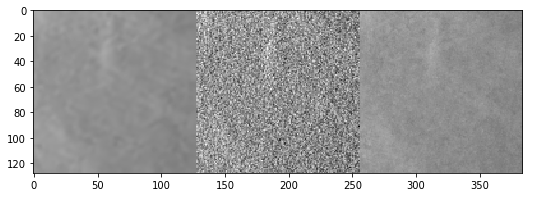

In [281]:
index = random.randint(0, len(output_result)-1)
plt.figure(figsize=(9,3))
print(np.mean(np.abs(output_result[index, 0, :, :]-style_batch[index, 0, :, :])))
plt.imshow(np.concatenate([output_result[index, 0, :, :], content_batch[index, 0, :, :], style_batch[index, 0, :, :]], axis=-1), cmap='gray')

In [3]:
def style_transfer(
        content=None,
        content_dir=None,
        content_size=512,
        style=None,
        style_dir=None,
        style_size=512,
        crop=None,
        preserve_color=None,
        alpha=1.0,
        style_interp_weights=None,
        mask=None,
        output_dir='output',
        save_ext='jpg',
        gpu=0,
        vgg_weights='models/vgg19_weights_normalized.h5',
        decoder_weights='models/decoder_weights.h5'):
    #assert bool(content) != bool(content_dir), 'Either content or content_dir should be given'
    #assert bool(style) != bool(style_dir), 'Either style or style_dir should be given'

    #if not os.path.exists(output_dir):
    #    print('Creating output dir at', output_dir)
    #    os.mkdir(output_dir)

    # Assume that it is either an h5 file or a name of a TensorFlow checkpoint
    decoder_in_h5 = False#"/home/pranjal/tf-adain/checkpoints/adain-240000"#decoder_weights.endswith('.h5')
    
    content_batch, style_batch = get_my_batch()
    
    print('Number of content images:', len(content_batch))
    print('Number of style images:', len(style_batch))

    data_format = 'channels_first'
    image, content, style, target, encoder, decoder = _build_graph(vgg_weights,
        decoder_weights if decoder_in_h5 else None, alpha, data_format=data_format)
    
    all_outputs = []
    #all_inputs 
    with tf.Session() as sess:
        if decoder_in_h5:
            sess.run(tf.global_variables_initializer())
        else:
            saver = tf.train.Saver()
            saver.restore(sess, decoder_weights)

        for k in range(len(content_batch)):
            content_image = content_batch[k]
            style_image   = style_batch[k]
            
            style_feature = sess.run(encoder, feed_dict={
                image: style_image[np.newaxis,:]
            })
            content_feature = sess.run(encoder, feed_dict={
                image: content_image[np.newaxis,:]
            })
            target_feature = sess.run(target, feed_dict={
                content: content_feature,
                style: style_feature
            })

            output = sess.run(decoder, feed_dict={
                content: content_feature,
                target: target_feature
            })
            
            all_outputs.append(output)
            #print("Output shape is ", output)
            
    return content_batch, style_batch, all_outputs

def _build_graph(vgg_weights, decoder_weights, alpha, data_format):
    if data_format == 'channels_first':
        image = tf.placeholder(shape=(None,3,None,None), dtype=tf.float32)
        content = tf.placeholder(shape=(1,512,None,None), dtype=tf.float32)
        style = tf.placeholder(shape=(1,512,None,None), dtype=tf.float32)
    else:
        image = tf.placeholder(shape=(None,None,None,3), dtype=tf.float32)
        content = tf.placeholder(shape=(1,None,None,512), dtype=tf.float32)
        style = tf.placeholder(shape=(1,None,None,512), dtype=tf.float32)

    target = adain(content, style, data_format=data_format)
    weighted_target = target * alpha + (1 - alpha) * content

    with open_weights(vgg_weights) as w:
        vgg = build_vgg(image, w, data_format=data_format)
        encoder = vgg['conv4_1']

    if decoder_weights:
        with open_weights(decoder_weights) as w:
            print(w)
            decoder = build_decoder(weighted_target, w, trainable=False,
                data_format=data_format)
    else:
        decoder = build_decoder(weighted_target, None, trainable=False,
            data_format=data_format)

    return image, content, style, target, encoder, decoder

In [ ]:
content_batch, style_batch, all_outputs = style_transfer()

all_outputs   = np.array(all_outputs)
content_batch = np.array(content_batch)
style_batch = np.array(style_batch)

print(all_outputs.shape, content_batch.shape, style_batch.shape)

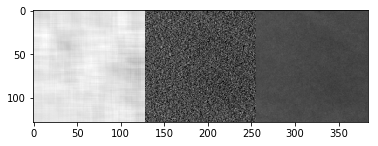

In [9]:
index = random.randint(0, len(all_outputs))
plt.imshow(np.concatenate([all_outputs[index, 0, 0, :, :], content_batch[index, 0, :, :,], style_batch[index, 0, :, :,]], axis=-1), cmap='gray')

In [ ]:
# CNN Models

def unet_double(pretrained_weights = None, input_size = (128, 128, 5), ):
    filter1 = 64
    filter2 = 128
    filter3 = 256
    filter4 = 512
    filter5 = 1024
    
    input1 = Input(input_size)
    input2 = Input((1, ))
    input3 = Input((1, ))
    
    hash_val1 = Dense(128, activation='relu')(input2)
    hash_val1 = Dense(1, activation='relu')(hash_val1)
    
    hash_val2 = Dense(128, activation='relu')(input3)
    hash_val2 = Dense(1, activation='relu')(hash_val2)
    
    hash_val = Multiply()([hash_val1, hash_val2])
    
    hash_val = Dense(128, activation='relu')(hash_val)
    hash_val = Dense(1, activation='relu')(hash_val)
    
    conv1 = Conv2D(filter1, 3, padding = 'same', kernel_initializer = 'he_normal')(input1)
    conv1 = LeakyReLU(0.2)(conv1)
    conv1 = Conv2D(filter1, 3, padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = LeakyReLU(0.2)(conv1)
    conv1 = Multiply()([hash_val, conv1])
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(filter2, 3, padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = LeakyReLU(0.2)(conv2)
    conv2 = Conv2D(filter2, 3, padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2 = LeakyReLU(0.2)(conv2)
    conv2 = Multiply()([hash_val, conv2])
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = LeakyReLU(0.2)(conv3)
    conv3 = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 = LeakyReLU(0.2)(conv3)
    conv3 = Multiply()([hash_val, conv3])
    
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = LeakyReLU(0.2)(conv4)
    conv4 = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv4)
    conv4 = LeakyReLU(0.2)(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
    pool4 = Multiply()([hash_val, pool4])
    
    conv5 = Conv2D(filter5, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = LeakyReLU(0.2)(conv5)
    conv5 = Conv2D(filter5, 3, padding = 'same', kernel_initializer = 'he_normal')(conv5)
    conv5 = LeakyReLU(0.2)(conv5)
    drop5 = Dropout(0.5)(conv5)
    drop5 = Multiply()([hash_val, drop5])
    
    up6    = Conv2D(filter4, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    up6    = LeakyReLU(0.2)(up6)
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6  = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6  = LeakyReLU(0.2)(conv6)
    conv6  = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv6)
    conv6  = LeakyReLU(0.2)(conv6)
    conv6  = Multiply()([hash_val, conv6])
        
    up7    = Conv2D(filter3, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    up7    = LeakyReLU(0.2)(up7)
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7  = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7  = LeakyReLU(0.2)(conv7)
    conv7  = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv7)
    conv7  = LeakyReLU(0.2)(conv7)
    conv7  = Multiply()([hash_val, conv7])
    
    up8    = Conv2D(filter2, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    up8    = LeakyReLU(0.2)(up8)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8  = Conv2D(filter2, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8  = LeakyReLU(0.2)(conv8)
    conv8  = Conv2D(filter2, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv8  = LeakyReLU(0.2)(conv8)
    conv8  = Multiply()([hash_val, conv8])
    
    up9    = Conv2D(filter1, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    up9    = LeakyReLU(0.2)(up9)
    merge9 = concatenate([conv1,up9], axis = 3)
    
    conv9  = Conv2D(filter1, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9  = LeakyReLU(0.2)(conv9)
    conv9  = Conv2D(filter1, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9  = LeakyReLU(0.2)(conv9)
    conv9  = Conv2D(1, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9  = LeakyReLU(0.2)(conv9)
    
    input_last  = Lambda(lambda x: x[:, :, :, 4])(input1)
    input_last  = Reshape([128, 128, 1])(input_last)
    
    conv10 = Subtract()([input_last, conv9])
    model  = Model(input = [input1, input2, input3], output = conv10)
    model.compile(optimizer = Adam(lr = 1e-4), loss = 'mean_absolute_error', metrics = ['mse'])
    
    #model.summary()
    return model

def unet_vanilla(pretrained_weights = None, input_size = (128, 128, 1), ):
    filter1 = 32
    filter2 = 64
    filter3 = 128
    filter4 = 256
    filter5 = 512
    
    input1 = Input(input_size)
    #input2 = Input((1, ))
    
    #hash_val = Dense(128, activation='relu')(input2)
    #hash_val = Dense(32, activation='relu')(hash_val)
    #hash_val = Dense(1, activation='relu')(hash_val)
    
    #input_mul = Multiply()([hash_val, input1])
    
    conv1 = Conv2D(filter1, 3, padding = 'same', kernel_initializer = 'he_normal')(input1)
    conv1 = LeakyReLU(0.2)(conv1)
    conv1 = Conv2D(filter1, 3, padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = LeakyReLU(0.2)(conv1)
    #conv1 = Multiply()([hash_val, conv1])
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(filter2, 3, padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = LeakyReLU(0.2)(conv2)
    conv2 = Conv2D(filter2, 3, padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2 = LeakyReLU(0.2)(conv2)
    #conv2 = Multiply()([hash_val, conv2])
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = LeakyReLU(0.2)(conv3)
    conv3 = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 = LeakyReLU(0.2)(conv3)
    #conv3 = Multiply()([hash_val, conv3])
    
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = LeakyReLU(0.2)(conv4)
    conv4 = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv4)
    conv4 = LeakyReLU(0.2)(conv4)
    drop4 = Dropout(0.1)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
    #pool4 = Multiply()([hash_val, pool4])
    
    conv5 = Conv2D(filter5, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = LeakyReLU(0.2)(conv5)
    conv5 = Conv2D(filter5, 3, padding = 'same', kernel_initializer = 'he_normal')(conv5)
    conv5 = LeakyReLU(0.2)(conv5)
    drop5 = Dropout(0.1)(conv5)
    #drop5 = Multiply()([hash_val, drop5])
    
    up6    = Conv2D(filter4, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    up6    = LeakyReLU(0.2)(up6)
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6  = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6  = LeakyReLU(0.2)(conv6)
    conv6  = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv6)
    conv6  = LeakyReLU(0.2)(conv6)
    #conv6  = Multiply()([hash_val, conv6])
        
    up7    = Conv2D(filter3, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    up7    = LeakyReLU(0.2)(up7)
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7  = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7  = LeakyReLU(0.2)(conv7)
    conv7  = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv7)
    conv7  = LeakyReLU(0.2)(conv7)
    #conv7  = Multiply()([hash_val, conv7])
    
    up8    = Conv2D(filter2, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    up8    = LeakyReLU(0.2)(up8)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8  = Conv2D(filter2, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8  = LeakyReLU(0.2)(conv8)
    conv8  = Conv2D(filter2, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv8  = LeakyReLU(0.2)(conv8)
    #conv8  = Multiply()([hash_val, conv8])
    
    up9    = Conv2D(filter1, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    up9    = LeakyReLU(0.2)(up9)
    merge9 = concatenate([conv1,up9], axis = 3)
    
    conv9  = Conv2D(filter1, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9  = LeakyReLU(0.2)(conv9)
    conv9  = Conv2D(filter1, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9  = LeakyReLU(0.2)(conv9)
    conv9  = Conv2D(1, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9  = LeakyReLU(0.2)(conv9)
    
    #input_last  = Lambda(lambda x: x[:, :, :, 4])(input1)
    input_last  = input1#Reshape([128, 128, 1])(input_last)
    
    conv10 = Subtract()([input_last, conv9])
    model  = Model(input = input1, output = conv10)
    model.compile(optimizer = Adam(lr = 1e-4), loss = 'mean_absolute_error', metrics = ['mse'])
    
    #model.summary()
    return model

def unet_two(pretrained_weights = None, input_size = (128, 128, 1), ):
    filter1 = 64
    filter2 = 128
    filter3 = 256
    filter4 = 512
    filter5 = 512
    
    input1 = Input(input_size)
    input2 = Input((1, ))
    
    hash_val = Dense(128, activation='relu')(input2)
    hash_val = Dropout(0.3)(hash_val)
    hash_val = Dense(32, activation='relu')(hash_val)
    hash_val = Dense(1, activation='relu')(hash_val)
    
    hash_val1 = Dense(128, activation='relu')(input2)
    hash_val1 = Dropout(0.3)(hash_val1)
    hash_val1 = Dense(32, activation='relu')(hash_val1)
    hash_val1 = Dense(1, activation='relu')(hash_val1)
    
    input_mul = Multiply()([hash_val, input1])
    
    conv1 = Conv2D(filter1, 3, padding = 'same', kernel_initializer = 'he_normal')(input1)
    conv1 = LeakyReLU(0.2)(conv1)
    conv1 = Conv2D(filter1, 3, padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = LeakyReLU(0.2)(conv1)
    conv1 = Multiply()([hash_val, conv1])
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(filter2, 3, padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = LeakyReLU(0.2)(conv2)
    conv2 = Conv2D(filter2, 3, padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2 = LeakyReLU(0.2)(conv2)
    conv2 = Dropout(0.2)(conv2)
    conv2 = Multiply()([hash_val, conv2])
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = LeakyReLU(0.2)(conv3)
    conv3 = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 = LeakyReLU(0.2)(conv3)
    conv3 = Multiply()([hash_val, conv3])
    
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = LeakyReLU(0.2)(conv4)
    conv4 = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv4)
    conv4 = LeakyReLU(0.2)(conv4)
    drop4 = Dropout(0.2)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
    pool4 = Multiply()([hash_val, pool4])
    
    conv5 = Conv2D(filter5, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = LeakyReLU(0.2)(conv5)
    conv5 = Conv2D(filter5, 3, padding = 'same', kernel_initializer = 'he_normal')(conv5)
    conv5 = LeakyReLU(0.2)(conv5)
    drop5 = Dropout(0.2)(conv5)
    drop5 = Multiply()([hash_val, drop5])
    
    up6    = Conv2D(filter4, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    up6    = LeakyReLU(0.2)(up6)
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6  = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6  = LeakyReLU(0.2)(conv6)
    conv6  = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv6)
    conv6  = LeakyReLU(0.2)(conv6)
    conv6  = Dropout(0.2)(conv6)
    conv6  = Multiply()([hash_val1, conv6])
        
    up7    = Conv2D(filter3, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    up7    = LeakyReLU(0.2)(up7)
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7  = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7  = LeakyReLU(0.2)(conv7)
    conv7  = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv7)
    conv7  = LeakyReLU(0.2)(conv7)
    conv7  = Dropout(0.2)(conv7)
    conv7  = Multiply()([hash_val1, conv7])
    
    up8    = Conv2D(filter2, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    up8    = LeakyReLU(0.2)(up8)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8  = Conv2D(filter2, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8  = LeakyReLU(0.2)(conv8)
    conv8  = Conv2D(filter2, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv8  = LeakyReLU(0.2)(conv8)
    conv8  = Dropout(0.2)(conv8)
    conv8  = Multiply()([hash_val1, conv8])
    
    up9    = Conv2D(filter1, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    up9    = LeakyReLU(0.2)(up9)
    merge9 = concatenate([conv1,up9], axis = 3)
    
    conv9  = Conv2D(filter1, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9  = LeakyReLU(0.2)(conv9)
    conv9  = Conv2D(filter1, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9  = LeakyReLU(0.2)(conv9)
    conv9  = Conv2D(1, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9  = LeakyReLU(0.2)(conv9)
    
    #input_last  = Lambda(lambda x: x[:, :, :, 4])(input1)
    input_last  = input1#Reshape([128, 128, 1])(input_last)
    
    conv10 = Subtract()([input_last, conv9])
    model  = Model(input = [input1, input2], output = conv10)
    model.compile(optimizer = Adam(lr = 1e-4), loss = 'mean_absolute_error', metrics = ['mse'])
    
    #model.summary()
    return model

def unet(pretrained_weights = None, input_size = (128, 128, 1), ):
    filter1 = 32
    filter2 = 64
    filter3 = 128
    filter4 = 256
    filter5 = 512
    
    input1 = Input(input_size)
    input2 = Input((1, ))
    
    hash_val = Dense(128, activation='relu')(input2)
    hash_val = Dropout(0.3)(hash_val)
    hash_val = Dense(32, activation='relu')(hash_val)
    hash_val = Dense(1, activation='relu')(hash_val)
    
    input_mul = Multiply()([hash_val, input1])
    
    conv1 = Conv2D(filter1, 3, padding = 'same', kernel_initializer = 'he_normal')(input1)
    conv1 = LeakyReLU(0.2)(conv1)
    conv1 = Conv2D(filter1, 3, padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = LeakyReLU(0.2)(conv1)
    conv1 = Multiply()([hash_val, conv1])
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(filter2, 3, padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = LeakyReLU(0.2)(conv2)
    conv2 = Conv2D(filter2, 3, padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2 = LeakyReLU(0.2)(conv2)
    conv2 = Dropout(0.2)(conv2)
    conv2 = Multiply()([hash_val, conv2])
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = LeakyReLU(0.2)(conv3)
    conv3 = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 = LeakyReLU(0.2)(conv3)
    conv3 = Multiply()([hash_val, conv3])
    
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = LeakyReLU(0.2)(conv4)
    conv4 = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv4)
    conv4 = LeakyReLU(0.2)(conv4)
    drop4 = Dropout(0.2)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
    pool4 = Multiply()([hash_val, pool4])
    
    conv5 = Conv2D(filter5, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = LeakyReLU(0.2)(conv5)
    conv5 = Conv2D(filter5, 3, padding = 'same', kernel_initializer = 'he_normal')(conv5)
    conv5 = LeakyReLU(0.2)(conv5)
    drop5 = Dropout(0.2)(conv5)
    drop5 = Multiply()([hash_val, drop5])
    
    up6    = Conv2D(filter4, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    up6    = LeakyReLU(0.2)(up6)
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6  = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6  = LeakyReLU(0.2)(conv6)
    conv6  = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv6)
    conv6  = LeakyReLU(0.2)(conv6)
    conv6  = Dropout(0.2)(conv6)
    conv6  = Multiply()([hash_val, conv6])
        
    up7    = Conv2D(filter3, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    up7    = LeakyReLU(0.2)(up7)
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7  = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7  = LeakyReLU(0.2)(conv7)
    conv7  = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv7)
    conv7  = LeakyReLU(0.2)(conv7)
    conv7  = Dropout(0.2)(conv7)
    conv7  = Multiply()([hash_val, conv7])
    
    up8    = Conv2D(filter2, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    up8    = LeakyReLU(0.2)(up8)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8  = Conv2D(filter2, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8  = LeakyReLU(0.2)(conv8)
    conv8  = Conv2D(filter2, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv8  = LeakyReLU(0.2)(conv8)
    conv8  = Dropout(0.2)(conv8)
    conv8  = Multiply()([hash_val, conv8])
    
    up9    = Conv2D(filter1, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    up9    = LeakyReLU(0.2)(up9)
    merge9 = concatenate([conv1,up9], axis = 3)
    
    conv9  = Conv2D(filter1, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9  = LeakyReLU(0.2)(conv9)
    conv9  = Conv2D(filter1, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9  = LeakyReLU(0.2)(conv9)
    conv9  = Conv2D(1, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9  = LeakyReLU(0.2)(conv9)
    
    #input_last  = Lambda(lambda x: x[:, :, :, 4])(input1)
    input_last  = input1#Reshape([128, 128, 1])(input_last)
    
    conv10 = Subtract()([input_last, conv9])
    model  = Model(input = [input1, input2], output = conv10)
    model.compile(optimizer = Adam(lr = 1e-5), loss = 'mse', metrics = ['mean_absolute_error'])
    
    #model.summary()
    return model

def unet_lstm(pretrained_weights = None, input_size = (128, 128, 2), ):
    filter1 = 32
    filter2 = 64
    filter3 = 128
    filter4 = 256
    filter5 = 512
    
    single_input = Input(input_size)
    
    input1 = Lambda(lambda x: x[:, :, :, 0])(single_input)
    input1 = Reshape([128, 128, 1])(input1)
    
    input2 = Lambda(lambda x: x[:, :, :, 1])(single_input)
    input2 = Flatten()(input2)
    input2 = Reshape([1, 128*128])(input2) 
    input2 = Lambda(lambda x: x[:, :, 0])(input2)
    
    hash_val = Dense(128, activation='relu')(input2)
    hash_val = Dense(1, activation='relu')(hash_val)
        
    conv1 = Conv2D(filter1, 3, padding = 'same', kernel_initializer = 'he_normal')(input1)
    conv1 = LeakyReLU(0.2)(conv1)
    conv1 = Conv2D(filter1, 3, padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = LeakyReLU(0.2)(conv1)
    conv1 = Multiply()([hash_val, conv1])
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(filter2, 3, padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = LeakyReLU(0.2)(conv2)
    conv2 = Conv2D(filter2, 3, padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2 = LeakyReLU(0.2)(conv2)
    conv2 = Multiply()([hash_val, conv2])
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = LeakyReLU(0.2)(conv3)
    conv3 = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 = LeakyReLU(0.2)(conv3)
    conv3 = Multiply()([hash_val, conv3])
    
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = LeakyReLU(0.2)(conv4)
    conv4 = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv4)
    conv4 = LeakyReLU(0.2)(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
    pool4 = Multiply()([hash_val, pool4])
    
    conv5 = Conv2D(filter5, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = LeakyReLU(0.2)(conv5)
    conv5 = Conv2D(filter5, 3, padding = 'same', kernel_initializer = 'he_normal')(conv5)
    conv5 = LeakyReLU(0.2)(conv5)
    drop5 = Dropout(0.5)(conv5)
    drop5 = Multiply()([hash_val, drop5])
    
    up6    = Conv2D(filter4, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    up6    = LeakyReLU(0.2)(up6)
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6  = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6  = LeakyReLU(0.2)(conv6)
    conv6  = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv6)
    conv6  = LeakyReLU(0.2)(conv6)
    conv6  = Multiply()([hash_val, conv6])
        
    up7    = Conv2D(filter3, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    up7    = LeakyReLU(0.2)(up7)
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7  = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7  = LeakyReLU(0.2)(conv7)
    conv7  = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv7)
    conv7  = LeakyReLU(0.2)(conv7)
    conv7  = Multiply()([hash_val, conv7])
    
    up8    = Conv2D(filter2, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    up8    = LeakyReLU(0.2)(up8)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8  = Conv2D(filter2, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8  = LeakyReLU(0.2)(conv8)
    conv8  = Conv2D(filter2, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv8  = LeakyReLU(0.2)(conv8)
    conv8  = Multiply()([hash_val, conv8])
    
    up9    = Conv2D(filter1, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    up9    = LeakyReLU(0.2)(up9)
    merge9 = concatenate([conv1,up9], axis = 3)
    
    conv9  = Conv2D(filter1, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9  = LeakyReLU(0.2)(conv9)
    conv9  = Conv2D(filter1, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9  = LeakyReLU(0.2)(conv9)
    conv9  = Conv2D(1, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9  = LeakyReLU(0.2)(conv9)
    
    #conv10 = Subtract()([input1, conv9])
    
    model  = Model(input = single_input, output = conv9)
    #model.compile(optimizer = Adam(lr = 1e-4), loss = 'mean_absolute_error', metrics = ['mse'])
    
    #model.summary()
    return model

def lstm_model():
    input_size = (5, 128, 128, 1)
    
    input1     = Input(input_size)
    input2     = Input((1, ))
    
    cnn_model  = unet()
    
    #time2       = TimeDistributed(cnn_model)(input1)
    
    lstm_out1   = ConvLSTM2D(filters=32, kernel_size=(3, 3), input_shape=(5, 128, 128, 1),
                             padding='same', activation=LeakyReLU(alpha=0.2), return_sequences=True)(input1)
    
    lstm_out2   = ConvLSTM2D(filters=1, kernel_size=(3, 3), padding='same', activation=LeakyReLU(alpha=0.2),
                            return_sequences=False)(lstm_out1)
    
    input_one = Lambda(lambda x: x[:, 4, :, :, :])(input1)
    input_one = Reshape([128, 128, 1])(input_one)
    
    cnn_out1   = cnn_model([lstm_out2, input2])
    
    final_out = Subtract()([input_one, cnn_out1])
    #lstm_out1   = ConvLSTM2D(filters=40, kernel_size=(3, 3), input_shape=(5, 128, 128, 1),
    #                         padding='same', activation=LeakyReLU(alpha=0.2), return_sequences=True)(lstm_out1)
    #lstm_out1   = ConvLSTM2D(filters=40, kernel_size=(3, 3), input_shape=(5, 128, 128, 1),
    #                         padding='same', activation=LeakyReLU(alpha=0.2), return_sequences=True)(lstm_out1)
    #lstm_out2   = ConvLSTM2D(filters=1, kernel_size=(3, 3), padding='same', activation=LeakyReLU(alpha=0.2),
    #                         return_sequences=False)(lstm_out1)
    
    #input_last  = Lambda(lambda x: x[:, 4, :, :, 0])(input1)
    #input_last  = Reshape([128, 128, 1])(input_last)
    
    #conv10      = Subtract()([input1, lstm_out2])
    
    time_model  = Model(input = [input1, input2], output = final_out)
    time_model.compile(optimizer = Adam(lr = 1e-4), 
                  loss = 'mean_absolute_error', 
                  metrics = ['mse'])
    
    return time_model

def conv_lstm_model():
    seq = Sequential()
    seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                       input_shape=(5, 128, 128, 1),
                       padding='same', return_sequences=True))
    #seq.add(BatchNormalization())

    seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                       padding='same', return_sequences=True))
    #seq.add(BatchNormalization())

    seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                       padding='same', return_sequences=True))
    #seq.add(BatchNormalization())

    seq.add(ConvLSTM2D(filters=1, kernel_size=(3, 3),
                       padding='same', return_sequences=False))
    #seq.add(BatchNormalization())

    #seq.add(Conv3D(filters=1, kernel_size=(3, 3, 3),
    #               activation='sigmoid',
    #               padding='same', data_format='channels_last'))
    
    seq.compile(loss='binary_crossentropy', optimizer='adadelta')
    
    return seq

def unet_combined(pretrained_weights = None, input_size = (128, 128, 1)):
    base_model  = unet()
    base_model.load_weights("all-data-0-to-7-0.0005-5.h5")

    filter1 = 32
    filter2 = 32
    filter3 = 32
    
    input1 = Input(input_size)
    input2 = Input(input_size)
    
    input1_1 = Input((1, ))
    input1_2 = Input((1, ))
    input1_3 = Input((1, ))
    input1_4 = Input((1, ))
    input1_5 = Input((1, ))
    input1_6 = Input((1, ))
    input1_7 = Input((1, ))
    
    for t in base_model.layers:
        t.trainable = False
    
    w1    = Concatenate()([input1, input2])
    
    conv1 = Conv2D(filter1, 3, padding = 'same', kernel_initializer = 'he_normal')(w1)
    conv1 = LeakyReLU(0.2)(conv1)
    conv1 = Conv2D(filter2, 3, padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = LeakyReLU(0.2)(conv1)
    conv1 = Conv2D(filter3, 3, padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = LeakyReLU(0.2)(conv1)
    
    layer_output = base_model.layers[-4].output
    
    new_model    = Model(base_model.input, layer_output)
    
    r1 = new_model([input1, input1_1])
    r2 = new_model([input1, input1_2])
    r3 = new_model([input1, input1_3])
    r4 = new_model([input1, input1_4])
    r5 = new_model([input1, input1_5])
    r6 = new_model([input1, input1_6])
    r7 = new_model([input1, input1_7])
    
#     c1 = Reshape([128, 128, 1])(Lambda(lambda x: x[:, :, :, 0])(conv1))
#     c2 = Reshape([128, 128, 1])(Lambda(lambda x: x[:, :, :, 1])(conv1))
#     c3 = Reshape([128, 128, 1])(Lambda(lambda x: x[:, :, :, 2])(conv1))
#     c4 = Reshape([128, 128, 1])(Lambda(lambda x: x[:, :, :, 3])(conv1))
#     c5 = Reshape([128, 128, 1])(Lambda(lambda x: x[:, :, :, 4])(conv1))
#     c6 = Reshape([128, 128, 1])(Lambda(lambda x: x[:, :, :, 5])(conv1))
#     c7 = Reshape([128, 128, 1])(Lambda(lambda x: x[:, :, :, 6])(conv1))
    
    
#     q1 = Multiply()([conv1, r1])
#     q2 = Multiply()([conv1, r2])
#     q3 = Multiply()([conv1, r3])
#     q4 = Multiply()([conv1, r4])
#     q5 = Multiply()([conv1, r5])
#     q6 = Multiply()([conv1, r6])
#     q7 = Multiply()([conv1, r7])
    
    #ut   = Add()([q1, q2, q3, q4, q5, q6, q7])
    #ut   = Add()([c1, c2, c3, c4, c5, c6, c7])
    out   = Add()([r1, r2, r3, r4, r5, r6, r7])
    out   = Multiply()([conv1, out])
    
    conv1 = Conv2D(filter1, 3, padding = 'same', kernel_initializer = 'he_normal')(out)
    conv1 = LeakyReLU(0.2)(conv1)
    conv1 = Conv2D(filter1, 3, padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = LeakyReLU(0.2)(conv1)
    conv1 = Conv2D(filter1, 3, padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = LeakyReLU(0.2)(conv1)
    conv1 = Conv2D(1, 3, padding = 'same', kernel_initializer = 'he_normal')(conv1)
    out   = LeakyReLU(0.2)(conv1)
    
    #conv1 = Multiply()([hash_val, conv1])
    
    model1  = Model(input = [input1, input2, input1_1, input1_2, input1_3, input1_4, input1_5, input1_6, input1_7], output = out)
    
    model1.compile(optimizer = Adam(lr = 1e-4), loss = 'mean_absolute_error', metrics = ['mse'])
    return model1

m = unet_two()
print(m.summary())

In [286]:
train_list = ['CE18', 'CE28', 'CE14', 'CE25', 'CE24', 'CE11', 'CE05', 'CE20', 'CE12', 'CE22'] # Add this later: 'CE25'
test_list  = ['CE03', 'CE07' 'CE18', 'CE27', 'CE17']

x_array = np.zeros([14560, 128, 128, 1], dtype='float16')
y_array = np.zeros([14560, 128, 128, 1], dtype='float16')
z_array = np.zeros([14560, 1], dtype='float16')

x_val_array = np.zeros([7000, 128, 128, 1], dtype='float16')
y_val_array = np.zeros([7000, 128, 128, 1], dtype='float16')
z_val_array = np.zeros([7000, 1], dtype='float16')

# x_array = np.zeros([6750, 128, 128, 1], dtype='float16')
# y_array = np.zeros([6750, 128, 128, 1], dtype='float16')
# z_array = np.zeros([6750, 1], dtype='float16')

# x_val_array = np.zeros([3875, 128, 128, 1], dtype='float16')
# y_val_array = np.zeros([3875, 128, 128, 1], dtype='float16')
# z_val_array = np.zeros([3875, 1], dtype='float16')

# x_array = np.zeros([175*7, 128, 128, 1], dtype='float16')
# y_array = np.zeros([175*7, 128, 128, 1], dtype='float16')
# z_array = np.zeros([175*7, 1], dtype='float16')

# x_val_array = np.zeros([175*3, 128, 128, 1], dtype='float16')
# y_val_array = np.zeros([175*3, 128, 128, 1], dtype='float16')
# z_val_array = np.zeros([175*3, 1], dtype='float16')


total_count = 0
for name in train_list[:-3]:
    a = np.load('/media/pranjal/BackupPlus/SIEMENS/DBT_recon_data/x_array_random-'+name+'-2.npy')
    x_array[total_count:total_count+a.shape[0], :, :, :] = a
    
    a = np.load('/media/pranjal/BackupPlus/SIEMENS/DBT_recon_data/y_array_random-'+name+'-2.npy')
    y_array[total_count:total_count+a.shape[0], :, :, :] = a
    
    a = np.load('/media/pranjal/BackupPlus/SIEMENS/DBT_recon_data/z_array_random-'+name+'-2.npy')
    z_array[total_count:total_count+a.shape[0],  :]     = a
    
    total_count = total_count + a.shape[0]
print(total_count)

total_count = 0
for name in train_list[-3:]:
    a = np.load('/media/pranjal/BackupPlus/SIEMENS/DBT_recon_data/x_array_random-'+name+'-2.npy')
    x_val_array[total_count:total_count+a.shape[0], :, :, :] = a
    
    a = np.load('/media/pranjal/BackupPlus/SIEMENS/DBT_recon_data/y_array_random-'+name+'-2.npy')
    y_val_array[total_count:total_count+a.shape[0], :, :, :] = a
    
    a = np.load('/media/pranjal/BackupPlus/SIEMENS/DBT_recon_data/z_array_random-'+name+'-2.npy')
    z_val_array[total_count:total_count+a.shape[0],  :]     = a
    
    total_count = total_count + a.shape[0]

print(total_count)

14560
7000


In [294]:
model = unet_two()
#model.load_weights('all-data-0-to-7-0.0005-5.h5')
checkpoints = ModelCheckpoint('all-data-random2-0-to-7-0.0005-5-two-more-filters.h5', 
                                              monitor='val_loss', verbose=0, save_best_only=True, 
                                              save_weights_only=False, mode='auto', period=1)

model.fit([x_array, z_array], y_array, 
          validation_data=([x_val_array, z_val_array], y_val_array), 
          batch_size=8, 
          epochs=10000, 
          callbacks=[checkpoints])

Train on 14560 samples, validate on 7000 samples
Epoch 1/10000
14560/14560 [==============================] - 226s 15ms/step - loss: 0.0011 - mean_squared_error: 3.3113e-06 - val_loss: 8.3673e-04 - val_mean_squared_error: 3.2194e-06
Epoch 2/10000
14560/14560 [==============================] - 226s 16ms/step - loss: 6.2226e-04 - mean_squared_error: 9.4178e-07 - val_loss: 7.4404e-04 - val_mean_squared_error: 2.2781e-06
Epoch 3/10000
14560/14560 [==============================] - 227s 16ms/step - loss: 5.6848e-04 - mean_squared_error: 7.5415e-07 - val_loss: 7.3955e-04 - val_mean_squared_error: 2.3796e-06
Epoch 4/10000
14560/14560 [==============================] - 228s 16ms/step - loss: 5.3984e-04 - mean_squared_error: 6.6235e-07 - val_loss: 7.0682e-04 - val_mean_squared_error: 2.0763e-06
Epoch 5/10000
14560/14560 [==============================] - 228s 16ms/step - loss: 5.1928e-04 - mean_squared_error: 5.9784e-07 - val_loss: 6.8486e-04 - val_mean_squared_error: 1.7954e-06
Epoch 6/10000
1

14560/14560 [==============================] - 227s 16ms/step - loss: 2.6330e-04 - mean_squared_error: 1.2676e-07 - val_loss: 6.4432e-04 - val_mean_squared_error: 1.4884e-06
Epoch 88/10000
14560/14560 [==============================] - 227s 16ms/step - loss: 2.6178e-04 - mean_squared_error: 1.2502e-07 - val_loss: 6.4244e-04 - val_mean_squared_error: 1.5035e-06
Epoch 89/10000
14560/14560 [==============================] - 227s 16ms/step - loss: 2.6161e-04 - mean_squared_error: 1.2515e-07 - val_loss: 6.3932e-04 - val_mean_squared_error: 1.4479e-06
Epoch 90/10000
14560/14560 [==============================] - 227s 16ms/step - loss: 2.6061e-04 - mean_squared_error: 1.2424e-07 - val_loss: 6.5346e-04 - val_mean_squared_error: 1.4826e-06
Epoch 91/10000
14560/14560 [==============================] - 227s 16ms/step - loss: 2.6034e-04 - mean_squared_error: 1.2369e-07 - val_loss: 6.3743e-04 - val_mean_squared_error: 1.4495e-06
Epoch 92/10000
14560/14560 [==============================] - 227s 16m

14560/14560 [==============================] - 227s 16ms/step - loss: 2.2257e-04 - mean_squared_error: 9.0249e-08 - val_loss: 6.4039e-04 - val_mean_squared_error: 1.3479e-06
Epoch 174/10000
14560/14560 [==============================] - 227s 16ms/step - loss: 2.2190e-04 - mean_squared_error: 8.9457e-08 - val_loss: 6.4200e-04 - val_mean_squared_error: 1.3846e-06
Epoch 175/10000
14560/14560 [==============================] - 227s 16ms/step - loss: 2.2189e-04 - mean_squared_error: 8.9590e-08 - val_loss: 6.4216e-04 - val_mean_squared_error: 1.3638e-06
Epoch 176/10000
14560/14560 [==============================] - 227s 16ms/step - loss: 2.2194e-04 - mean_squared_error: 8.9797e-08 - val_loss: 6.5209e-04 - val_mean_squared_error: 1.4378e-06
Epoch 177/10000
14560/14560 [==============================] - 227s 16ms/step - loss: 2.2086e-04 - mean_squared_error: 8.8628e-08 - val_loss: 6.5247e-04 - val_mean_squared_error: 1.4030e-06
Epoch 178/10000
14560/14560 [==============================] - 228

KeyboardInterrupt: 

In [424]:
result = model.predict([x_val_array, z_val_array], batch_size=8)
print(result.shape)

(7000, 128, 128, 1)


[0.63] [0.625] [0.621] [0.617] [0.616]
(128, 640) (128, 640) (128, 640) (384, 640)


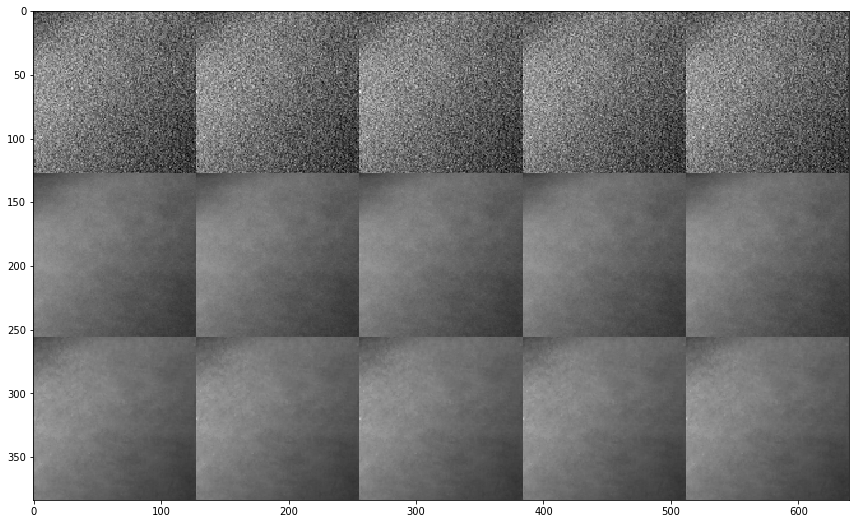

In [686]:
index = random.randint(100, len(x_val_array)-100)

print(z_val_array[index], z_val_array[index-1], z_val_array[index-2], z_val_array[index-3], z_val_array[index-4])
plt.figure(figsize=(27, 9))

t0 = np.concatenate([x_val_array[index, :, :, 0].astype('float32'), 
                           x_val_array[index-1, :, :, 0].astype('float32'),
                          x_val_array[index-2, :, :, 0].astype('float32'),
                          x_val_array[index-3, :, :, 0].astype('float32'),
                          x_val_array[index-4, :, :, 0].astype('float32')], axis=-1)

t1 = np.concatenate([y_val_array[index, :, :, 0].astype('float32'), 
                           y_val_array[index-1, :, :, 0].astype('float32'),
                          y_val_array[index-2, :, :, 0].astype('float32'),
                          y_val_array[index-3, :, :, 0].astype('float32'),
                          y_val_array[index-4, :, :, 0].astype('float32')], axis=-1)

t2 = np.concatenate([result[index, :, :, 0].astype('float32'), 
                           result[index-1, :, :, 0].astype('float32'),
                          result[index-2, :, :, 0].astype('float32'),
                          result[index-3, :, :, 0].astype('float32'),
                          result[index-4, :, :, 0].astype('float32')], axis=-1)
t4 = np.abs(t1-t2)
t3 = np.concatenate([t0, t1, t2], axis=0)
print(t0.shape, t1.shape, t2.shape, t3.shape)
plt.imshow(t3, cmap='gray')

# print(np.mean(np.abs(y_val_array[index, :, :, 0]-result[index, :, :, 0])))
# print(np.mean(np.abs(y_val_array[index-1, :, :, 0]-result[index-1, :, :, 0])))
# print(np.mean(np.abs(y_val_array[index-2, :, :, 0]-result[index-2, :, :, 0])))
# print(np.mean(np.abs(y_val_array[index-3, :, :, 0]-result[index-3, :, :, 0])))
# print(np.mean(np.abs(y_val_array[index-4, :, :, 0]-result[index-4, :, :, 0])))

In [751]:
allfiles = glob.glob("/media/pranjal/de24af8d-2361-4ea2-a07a-1801b54488d9/duke_phantom/Cohort1/Cohort1.1_compressed/Cohort1.1_compressed/*.img")

count = 0
for f in allfiles:
    tx = int(f.split("/")[-1].split("_")[2])
    ty = int(f.split("/")[-1].split("_")[3])
    tz = int(f.split("/")[-1].split("_")[4].split(".")[0])
    
    print(f.split("/")[-1], tx, ty, tz)
    
    fid   = open(f, 'rb')
    data  = np.fromfile(fid, "uint8")
    image = data.reshape([tz, ty, tx])
    image = np.moveaxis(image, 0, -1)
    
    #print(np.unique(image.flatten()))
    
    for k in range(2, 6):
        #print(k)
        image[image == k] = 29
    
    image[image == 6]   = 2
    print(image.shape)
    
    image.tofile("/media/pranjal/BackupPlus/CEDBT/CHO-DATA/phantom-"+str(count)+"_"+str(image.shape[2])+"x"+str(image.shape[1])+"x"+str(image.shape[0])+".raw")
    count = count+1

CTB5673_7cm_716_297_416.img 716 297 416
(297, 716, 416)
CTA1632_6cm_635_256_433.img 635 256 433
(256, 635, 433)
CTA1459_7cm_716_297_416.img 716 297 416
(297, 716, 416)
CTB4500_8cm_804_337_435.img 804 337 435
(337, 804, 435)
CTB5885_8cm_804_337_435.img 804 337 435
(337, 804, 435)
CTA0297_7cm_716_297_416.img 716 297 416
(297, 716, 416)
CTA0725_8cm_804_337_435.img 804 337 435
(337, 804, 435)
CTB4651_7cm_716_297_416.img 716 297 416
(297, 716, 416)
CTA0663_8cm_804_337_435.img 804 337 435
(337, 804, 435)
CTA0446_8cm_804_337_435.img 804 337 435
(337, 804, 435)
CTA1920_6cm_635_256_433.img 635 256 433
(256, 635, 433)
CTB5410_7cm_716_297_416.img 716 297 416
(297, 716, 416)
CTA0338_7cm_716_297_416.img 716 297 416
(297, 716, 416)
CTA1438_8cm_804_337_435.img 804 337 435
(337, 804, 435)
CTB5282_8cm_804_337_435.img 804 337 435
(337, 804, 435)
CTA0457_7cm_716_297_416.img 716 297 416
(297, 716, 416)
CTB5859_7cm_716_297_416.img 716 297 416
(297, 716, 416)
CTA0302_8cm_804_337_435.img 804 337 435
(337, 80

(256, 635, 433)
CTA0445_7cm_716_297_416.img 716 297 416
(297, 716, 416)
CTA0357_5cm_602_216_337.img 602 216 337
(216, 602, 337)
CTA1641_6cm_635_256_433.img 635 256 433
(256, 635, 433)
CTA1148_7cm_716_297_416.img 716 297 416
(297, 716, 416)
CTA1851_7cm_716_297_416.img 716 297 416
(297, 716, 416)
CTA1310_6cm_635_256_433.img 635 256 433
(256, 635, 433)
CTB5769_7cm_716_297_416.img 716 297 416
(297, 716, 416)
CTB4698_7cm_716_297_416.img 716 297 416
(297, 716, 416)
CTB5881_8cm_804_337_435.img 804 337 435
(337, 804, 435)
CTB4826_7cm_716_297_416.img 716 297 416
(297, 716, 416)
CTB6016_7cm_716_297_416.img 716 297 416
(297, 716, 416)
CTA1673_7cm_716_297_416.img 716 297 416
(297, 716, 416)
CTA0475_8cm_804_337_435.img 804 337 435
(337, 804, 435)
CTB4863_5cm_602_216_337.img 602 216 337
(216, 602, 337)
CTA1222_8cm_804_337_435.img 804 337 435
(337, 804, 435)
CTA1452_8cm_804_337_435.img 804 337 435
(337, 804, 435)
CTB5651_8cm_804_337_435.img 804 337 435
(337, 804, 435)
CTA0750_8cm_804_337_435.img 804 

In [805]:
train_lesions = allfiles[:25]
val_lesions   = allfiles[25:35]
test_lesions  = allfiles[25:35]

print(len(train_lesions), len(val_lesions), len(test_lesions))

np.save("/home/pranjal/VICTRE/victre_breastmass/breastMass/train_lesions.npy", train_lesions)
np.save("/home/pranjal/VICTRE/victre_breastmass/breastMass/val_lesions.npy",  val_lesions)
np.save("/home/pranjal/VICTRE/victre_breastmass/breastMass/test_lesions.npy",  test_lesions)

25 10 10


In [ ]:
allfiles = glob.glob("/home/pranjal/VICTRE/victre_breastmass/breastMass/mass*.raw")
print(len(allfiles))
for f in allfiles:
    print(f.split("/")[-1])

In [820]:
# Reading the lesions array

train_lesions = np.load("/home/pranjal/VICTRE/victre_breastmass/breastMass/train_lesions.npy")
train_lesions_array = []

for name in train_lesions:
    temp = np.fromfile(name, dtype='uint8')
    t    = int(name.split("_")[-1].split(".")[0])
    temp = np.reshape(temp, [t, t, t])
    train_lesions_array.append(temp)

In [ ]:
# Insert lesion loop

allfiles = glob.glob("/media/pranjal/BackupPlus/CEDBT/CHO-DATA/NO-LESION/*.raw")

def insert_lesion(image, z_slice, index):
    coord = []
    count = 0
    #index = random.randint(0, len(train_lesions)-1)
    
    while(count < 4):
        k     = count
        temp  = train_lesions_array[index]
        
        if temp.shape[0] > z_slice:
            continue
        
        #coord.append([z_slice-tx:z_slice+temp.shape[0]-tx, 150+k*120-tx:150+k*120+temp.shape[0]-tx, 100-tx:100+temp.shape[0]-tx])
        tx = int(temp.shape[0]/2)
        temp1 = image[z_slice-tx:z_slice+temp.shape[0]-tx, 150+k*120-tx:150+k*120+temp.shape[0]-tx, 100-tx:100+temp.shape[0]-tx]
        #print(temp1.shape, temp.shape)
        
        temp1[temp == 1] = 200
        image[z_slice-tx:z_slice+temp.shape[0]-tx, 150+k*120-tx:150+k*120+temp.shape[0]-tx, 100-tx:100+temp.shape[0]-tx] = temp1
        
        count = count+1
    
    count = 0 
    while(count < 4):
        k     = count
        temp  = train_lesions_array[index]
        
        if temp.shape[0] > z_slice:
            continue
    
        tx = int(temp.shape[0]/2)
    
        temp1 = image[z_slice-tx:z_slice+temp.shape[0]-tx, 150+k*120-tx:150+k*120+temp.shape[0]-tx, 200-tx:200+temp.shape[0]-tx]
        #print(temp1.shape, temp.shape)
        
        temp1[temp == 1] = 200
        image[z_slice-tx:z_slice+temp.shape[0]-tx, 150+k*120-tx:150+k*120+temp.shape[0]-tx, 200-tx:200+temp.shape[0]-tx] = temp1
        
        count = count+1
        
    return image
    
for f in allfiles:
    data = np.fromfile(f, dtype='uint8')
    
    tx = int(f.split("/")[-1].split("_")[1].split("x")[0])
    ty = int(f.split("/")[-1].split("_")[1].split("x")[1])
    tz = int(f.split("/")[-1].split("_")[1].split("x")[2].split(".")[0])
    
    name = f.split("/")[-1]
    
    image = data.reshape([tz, ty, tx])
    index = int(name.split("-")[1].split("_")[0])
    index = index%len(train_lesions)
    
    print(name, index)
    
    if image.shape[0] < 280:
        image = insert_lesion(image, 130, index)
    else:
        image = insert_lesion(image, 150, index)
    
    image.tofile("/media/pranjal/BackupPlus/CEDBT/CHO-DATA/WITH-LESION/"+name)
    

phantom-132_416x716x297.raw 7
phantom-157_416x716x297.raw 7
phantom-40_416x716x297.raw 15
phantom-36_435x804x337.raw 11
phantom-93_435x804x337.raw 18
phantom-122_416x716x297.raw 22
phantom-149_433x635x256.raw 24
phantom-75_435x804x337.raw 0
phantom-30_433x635x256.raw 5
phantom-121_435x804x337.raw 21
phantom-137_433x635x256.raw 12
phantom-119_416x716x297.raw 19
phantom-167_416x716x297.raw 17
phantom-32_416x716x297.raw 7
phantom-63_433x635x256.raw 13
phantom-95_435x804x337.raw 20
phantom-113_433x635x256.raw 13
phantom-92_435x804x337.raw 17
phantom-5_416x716x297.raw 5
phantom-97_435x804x337.raw 22
phantom-155_435x804x337.raw 5
phantom-52_435x804x337.raw 2
phantom-29_435x804x337.raw 4
phantom-15_416x716x297.raw 15
phantom-110_416x716x297.raw 10
phantom-0_416x716x297.raw 0
phantom-59_435x804x337.raw 9
phantom-145_416x716x297.raw 20
phantom-82_435x804x337.raw 7
phantom-117_416x716x297.raw 17
phantom-147_416x716x297.raw 22
phantom-176_435x804x337.raw 1
phantom-57_416x716x297.raw 7
phantom-78_

In [865]:
print(len(train_lesions))

25


In [788]:
image[150-78:150+78, 200-78:200+78, 100-78:100+78] = temp

In [785]:
temp[a == 1] = 200

In [780]:
temp = image[150-78:150+78, 200-78:200+78, 100-78:100+78]

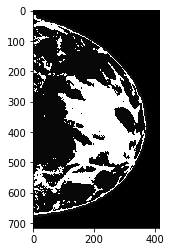

In [808]:
plt.imshow(a[70, :, :], cmap='gray')

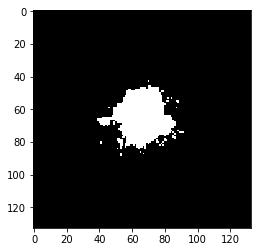

In [852]:
plt.imshow(temp[50, :, :], cmap='gray')

In [853]:
a = np.load("/home/pranjal/all_patches_lesion.npy")
b = np.load("/home/pranjal/all_patches_without_lesion.npy")

print(a.shape, b.shape)

(459, 8, 256, 256) (459, 8, 256, 256)


In [855]:
a1 = np.reshape(a, [a.shape[0]*8, 256,256])
b1 = np.reshape(b, [a.shape[0]*8, 256,256])

print(a1.shape, b1.shape)

(3672, 256, 256) (3672, 256, 256)


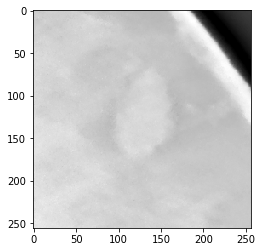

In [861]:
plt.imshow(a2[:, :, 100], cmap='gray')

In [862]:
a2 = np.transpose(a1, (1, 2, 0))
b2 = np.transpose(b1, (1, 2, 0))

#a2 = permute(a1, [1 3 2]);
print(a2.shape, b2.shape)

(256, 256, 3672) (256, 256, 3672)


In [863]:
np.save("/home/pranjal/all_patches_lesion.npy", a2)
np.save("/home/pranjal/all_patches_without_lesion.npy", b2)

In [864]:
# For storing as Matlab file

import scipy.io as sio

t1 = {}
t1['saroi'] = a2

t2 = {}
t2['sproi'] = b2

sio.savemat('/home/pranjal/VICTRE_MO/ffdm_saroi1.mat', t1)
sio.savemat('/home/pranjal/VICTRE_MO/ffdm_sproi1.mat', t2)


In [4]:
a       = sio.loadmat("/media/pranjal/BackupPlus/CEDBT/attenuation_values_cropped/LE/1.mat")["head"]
testvol = np.rollaxis(a, 2, 0)
testvol = np.moveaxis(testvol, [0, 1, 2], [0, 2, 1])
testvol = testvol/65.0

print(testvol.shape)

(320, 448, 800)


In [20]:
# SIRT reconstruction for Phantom

import astra
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import random
import time
import pydicom
import glob
from numba import jit
from skimage import filters
import copy
from scipy import ndimage, misc


@jit(nopython=True, parallel=True)
def my_divide(x, y):
    return np.divide(x, y)

@jit(nopython=True, parallel=True)
def my_add(x, y):
    return np.add(x, y)

@jit(nopython=True, parallel=True)
def my_mul(x, y):
    return np.multiply(x, y)



#testvol = ndimage.zoom(testvol, 0.25, order=1)
#testvol = np.zeros([320, 448, 800], dtype='uint8')

scaling_factor = 1

voxel_size = 0.02

SOD       = 65/(voxel_size*scaling_factor)
ODD       = 4.5/(voxel_size*scaling_factor)
detWidth  = 0.0085/(voxel_size/scaling_factor)   # size of each detector pixel
detHeight = detWidth                         # size of each detector pixel
detRows   = 3000
detCols   = 1504


num_angles = 25

#estimate = np.fromfile("/media/pranjal/2d33dff3-95f7-4dc0-9842-a9b18bcf1bf9/pranjal/DBT_data/ClinicalExample/CE-05_R/ce.800x448x320.05-le.raw", dtype='float32')
#estimate = np.reshape(estimate, [320, 448, 800])


a       = sio.loadmat("/media/pranjal/BackupPlus/CEDBT/attenuation_values_cropped/LE/1.mat")["head"]
testvol = np.rollaxis(a, 2, 0)
testvol = np.moveaxis(testvol, [0, 1, 2], [0, 2, 1])
testvol = testvol/65.0
print("Volume shape ", testvol.shape)

vol_geom = astra.create_vol_geom(int(testvol.shape[1]), int(testvol.shape[2]), int(testvol.shape[0]))
proj_arr = np.zeros((num_angles, detCols, detRows), dtype='float16')
testones = np.ones([int(testvol.shape[0]), int(testvol.shape[1]), int(testvol.shape[2])],  dtype='uint8')
estimate = np.zeros([int(testvol.shape[0]), int(testvol.shape[1]), int(testvol.shape[2])], dtype='float16')

print('Starting Recon')


#proj_arr = np.array(proj_arr).astype('float16')
#proj_arr = np.rollaxis(proj_arr, 1, 0)
#proj_arr = proj_arr.flatten()


# All Flags
insert_noise     = 0

for index in range(5, 6):
    print("Phantom ", index)
#     a       = sio.loadmat("/media/pranjal/BackupPlus/CEDBT/attenuation_values_cropped/LE/"+str(index)+".mat")["head"]
#     testvol = np.rollaxis(a, 2, 0)
#     testvol = np.moveaxis(testvol, [0, 1, 2], [0, 2, 1])
#     volume_mask = testvol > 0

    #testvol1 = np.fromfile('/media/pranjal/BackupPlus/CEDBT/SIRT/800x448x320-sart-0.raw', dtype='float32')
    #testvol  = np.reshape(testvol1, testvol.shape)
    
    # Get simulation angles
    start_angle = -21
    theta       = []
    for i in range(num_angles):
        theta.append(start_angle*np.pi/180.0)
        start_angle = start_angle+1.98#ang[i]


    #print(theta)
    vectors = np.zeros((len(theta), 12))

    # For reconstructing real data
    vectors[:, 0:3]  = np.transpose(np.array([np.sin(theta), np.zeros(len(theta)), np.cos(theta)])) * SOD        # S source to object
    vectors[:,3:6]   = np.transpose(np.array([np.zeros(len(theta)), np.zeros(len(theta)),  -np.ones(len(theta))*ODD]))             # D object to detector
    vectors[:,6:9]   = np.transpose(np.array([np.ones(len(theta))*detWidth, np.zeros(len(theta)), np.zeros(len(theta))]))         # U
    vectors[:,9:12]  = np.transpose(np.array([np.zeros(len(theta)), np.ones(len(theta))*detWidth, np.zeros(len(theta))]))        # V

    # Creating the projection matrix
    proj_geom        = astra.create_proj_geom('cone_vec', detCols, detRows, vectors)
    proj_id          = astra.create_projector('cuda3d',   proj_geom, vol_geom)
    W                = astra.OpTomo(proj_id)

    proj_arr         = W*testvol

    temp_proj = np.reshape(proj_arr, [detCols, num_angles, detRows])
    temp_proj = np.rollaxis(temp_proj, 0, 2)
    
    print(temp_proj.shape)

Volume shape  (320, 448, 800)
Starting Recon
Phantom  5
(25, 1504, 3000)


In [25]:
temp_proj.tofile("/media/pranjal/BackupPlus/CEDBT/proj-3000x1504x25.raw")

In [29]:
#if(insert_noise):

proj_arr  = temp_proj
I0        = 2000
proj      = I0*np.exp(-proj_arr)
proj_noi  = np.random.poisson(proj)

proj_noi[proj_noi == 0] = 1
g_noi                   = np.log(I0) - np.log(proj_noi) # convert back to line integrals 
g_noi[g_noi < 0]        = 0
proj_arr = g_noi

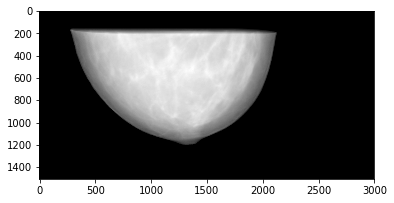

In [30]:
plt.imshow(temp_proj[24, :, :], cmap='gray')

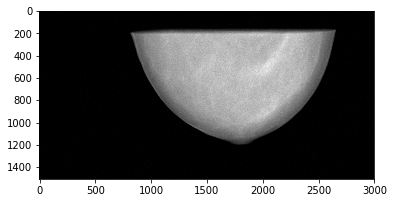

In [32]:
plt.imshow(proj_arr[0, :, :], cmap='gray')

In [19]:
testvol1 = np.fromfile("/media/pranjal/BackupPlus/CEDBT/CHO-DATA/WITH-LESION/phantom-33_435x804x337.raw", dtype='uint8')
testvol  = np.reshape(testvol1, [337, 804, 435])

print(testvol.shape)

(337, 804, 435)


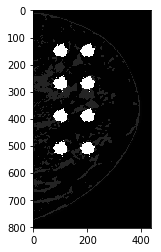

In [20]:
plt.imshow(testvol[150, :, :], cmap='gray')